In [1]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.extend(["../"])

time: 1.02 ms


In [3]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 318 ms


In [4]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'EC2GPU': '/home/ubuntu/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory MAC
time: 1.18 s


In [5]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=1)
LAGS = 6
df_d1.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


time: 35.8 ms


In [6]:
X_raw, y_raw = gen_supervised_sequence(
    df_d1, LAGS, "UNRATE_period1_order1", sequential_label=False)

Total 842 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (842, 6, 1), y shape = (842, 1, 1)
time: 102 ms


In [7]:
X_raw
y_raw = y_raw.reshape(-1,)

time: 429 µs


In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 8.74 ms


In [101]:
X_train = X_train.reshape(-1, LAGS)

time: 435 µs


In [102]:
X_scaler = sklearn.preprocessing.MinMaxScaler([-1, 1]).fit(X_train)
# y_scaler = sklearn.preprocessing.MinMaxScaler([-1, 1]).fit(y_train)

time: 1.2 ms


In [104]:
tx = lambda target: X_scaler.transform(target)
# ty = lambda target: y_scaler.transform(target)

X_train = tx(X_train)
X_test = tx(X_test.reshape(-1, LAGS))
X_val = tx(X_val.reshape(-1, LAGS))

# y_train = ty(y_train)
# y_test = ty(y_test)
# y_val = ty(y_val)

time: 1.37 ms


In [105]:
print(np.std(X_train))
print(np.std(y_train))

0.11948984770064149
0.23346976010575549
time: 997 µs


In [107]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

time: 656 µs


In [34]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

time: 648 µs


In [8]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (538, 6, 1)
y_train shape: (538, 1, 1)
X_test shape: (169, 6, 1)
y_test shape: (169, 1, 1)
X_validation shape: (135, 6, 1)
y_validation shape: (135, 1, 1)
time: 1.6 ms


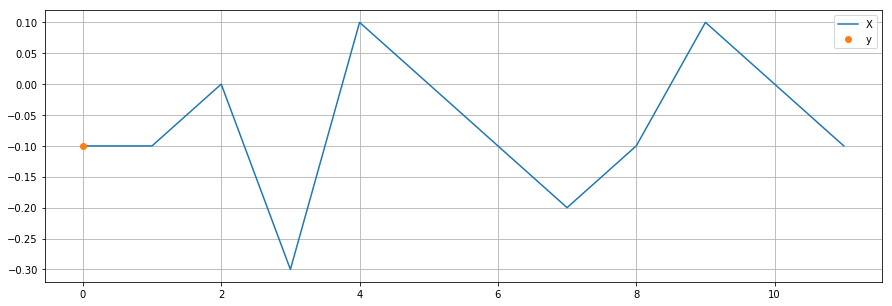

time: 212 ms


In [12]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[-1])
plt.plot(y_train[-2], "o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [14]:
# for t in range(100):
#     print(y_train[t] == X_train[t+1][-1])

time: 272 µs


In [10]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.03
epochs = 500
# Training Settings
REPORT_PERIOD = 10
PRINT_PERIOD = 100

time: 1.53 ms


In [66]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
# y = tf.placeholder(
#     tf.float32,
#     [None, num_time_steps, num_outputs],
#     name="Output_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, 1, num_outputs],
    name="Output_placeholder")

time: 3.99 ms


In [67]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

# stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
# Equivalently ====
W = tf.Variable(tf.random_normal([num_neurons, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal([1]),  dtype=tf.float32)
stacked_outputs2 = tf.add(tf.matmul(stacked_rnn_output, W), b)
# ====
outputs = tf.reshape(stacked_outputs2, [-1, num_time_steps, num_outputs])

time: 139 ms


In [68]:
stacked_outputs2

<tf.Tensor 'Add:0' shape=(?, 1) dtype=float32>

time: 2.62 ms


In [69]:
# outputs = tf.layers.dense(rnn_output, num_outputs)
# last_output = outputs[:, -1]

time: 675 µs


In [70]:
# Operators
loss = tf.reduce_mean(tf.square(outputs - y))
# loss = tf.reduce_mean(tf.square(last_output - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 322 ms


In [71]:
def progbar(curr, total, full_progbar):
    frac = curr/total
    filled_progbar = round(frac*full_progbar)
    print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), end='')

time: 1.6 ms


In [72]:
y_train.shape

(538, 1, 1)

time: 2.4 ms


In [73]:
hist = {"train": [], "val": [], "epoch": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        progbar(e, epochs-1, 0)
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % REPORT_PERIOD == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            hist["epoch"].append(e)
            if e % PRINT_PERIOD == 0:
                print(f"\nIteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

  [  0.00%]
Iteration [0], Training MSE 0.8814528; Validation MSE 0.7422032
  [ 20.04%]
Iteration [100], Training MSE 0.0500350; Validation MSE 0.0180988
  [ 40.08%]
Iteration [200], Training MSE 0.0467299; Validation MSE 0.0182638
  [ 60.12%]
Iteration [300], Training MSE 0.0453676; Validation MSE 0.0180593
  [ 80.16%]
Iteration [400], Training MSE 0.0441768; Validation MSE 0.0178971
  [100.00%]time: 8.15 s


In [74]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)

time: 623 µs


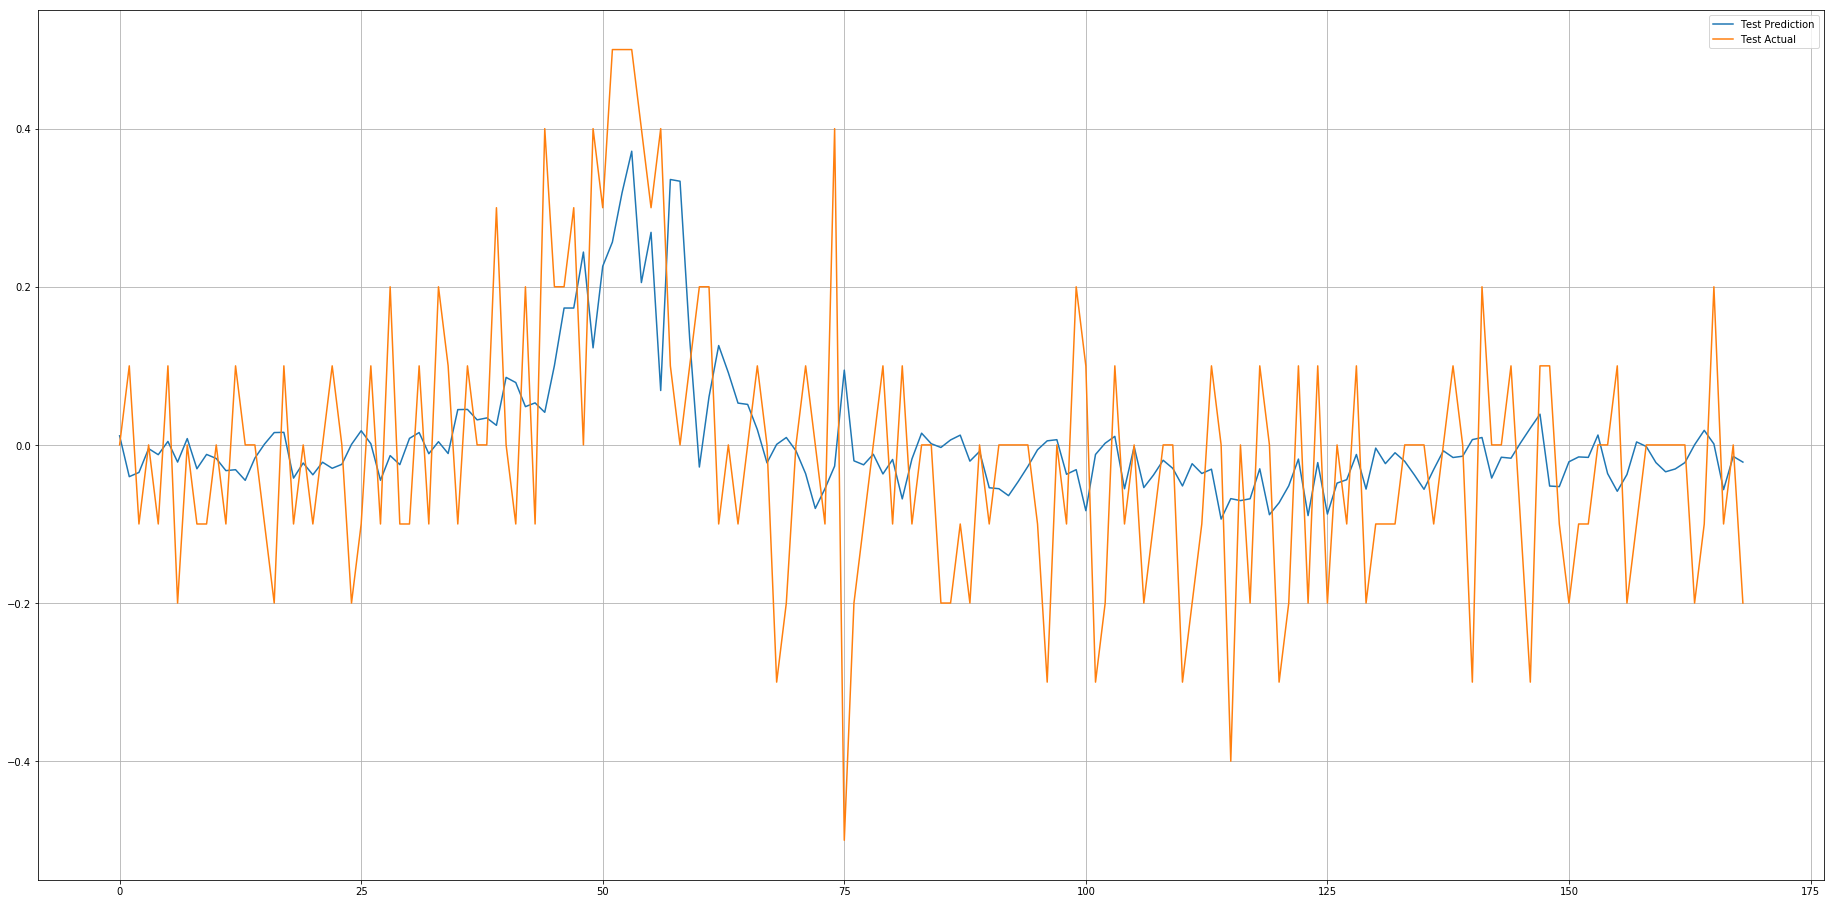

time: 964 ms


In [75]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

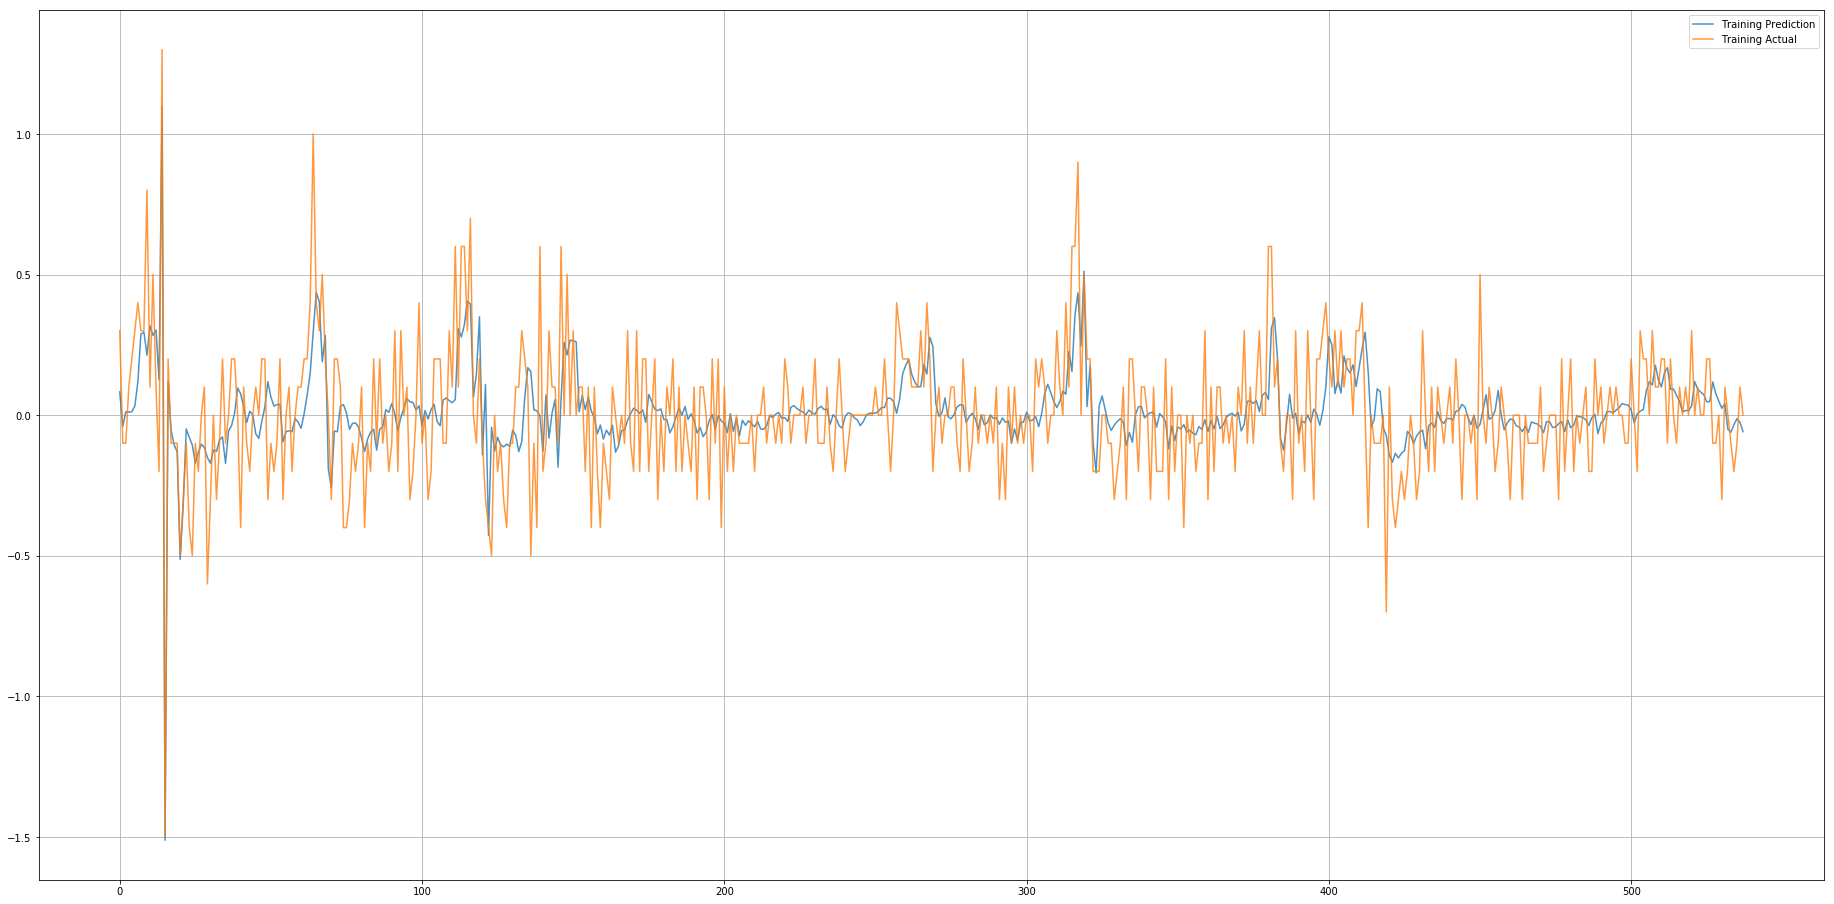

time: 1.22 s


In [76]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train), alpha=0.8)
plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

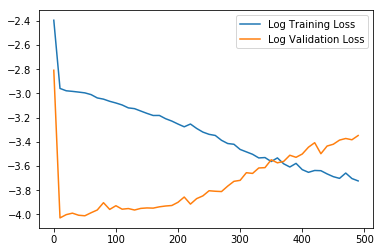

time: 138 ms


In [91]:
plt.close()
plt.plot(hist["epoch"], np.log(hist["train"]))
plt.plot(hist["epoch"], np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()